In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import spacy, os
from pathlib import Path
nlp = spacy.load('en_core_web_sm')
import graphviz
from sklearn import linear_model, metrics, preprocessing, tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Step 1: Data Understanding

In [2]:
# Getting text from files and putting into one dataframe
data = pd.DataFrame(columns=["Text","Sentiment"])
sets = ["train","test"]
for i in sets:
    sentiment = ["pos","neg"]
    for x in sentiment:

        folder = "IMDB_reviews/" + i + "/" + x
        text = []
        data_set = pd.DataFrame(columns=["Text","Sentiment"])

        for file in os.listdir(folder):
            filename = folder + "/" + os.fsdecode(file)
            textfile = open(filename, encoding="utf8")
            text.append(textfile.read().replace("<br />", " "))
        
        data_set["Text"] = text
        data_set["Sentiment"] = x
        data = pd.concat([data,data_set])    
        
data["Set"] = ""
data = data.reset_index()
data.loc[:1999, "Set"] = "Train"
data.loc[2000:, "Set"] = "Test"
data.loc[data.Sentiment == "pos", "Sentiment"] = 1
data.loc[data.Sentiment == "neg", "Sentiment"] = 0

#Limiting to 1000 records from each data set
data = data.loc[data["index"] < 1000]

data.head()

,index,Text,Sentiment,Set
0,0,Bromwell High is a cartoon comedy. It ran at t...,1,Train
1,1,Scott Bartlett's 'OffOn' is nine minutes of pu...,1,Train
2,2,"IMDb lists this as 1972 for some reason, but t...",1,Train
3,3,I first heard about this film about 20 years a...,1,Train
4,4,"when i read other comment,i decided to watch t...",1,Train


In [3]:
# Making sure each data set has 50/50 ratio of neg/pos reviews
data["Sentiment"].groupby(data["Set"]).value_counts()

Set    Sentiment
Test   0            1000
       1            1000
Train  0            1000
       1            1000
Name: Sentiment, dtype: int64

# Step 2: Data Preparation

## Training Data

In [4]:
# Tokenizing training data
training = data.loc[data.Set == "Train"]
token_data = pd.DataFrame(columns=["Token", "ID"])

for rownum, row in training.iterrows():
    doc = nlp(training.at[rownum,"Text"])
    token_set = pd.DataFrame(columns=["Token","ID"])
    tokens = []
    for token in doc:
        if (token.lemma_ != "-PRON-") & (token.pos_ != "PUNCT") & (token.pos_ != "SPACE") & (token.is_stop == False) & (len(token.lemma_) > 2):
            tokens.append(token.lemma_)

    token_set["Token"] = tokens
    token_set["ID"] = rownum
    token_data = pd.concat([token_data, token_set])

token_data

,Token,ID
0,bromwell,0
1,high,0
2,cartoon,0
3,comedy,0
4,run,0
5,time,0
6,program,0
7,school,0
8,life,0
9,teacher,0


In [5]:
# Getting features
features = pd.DataFrame(token_data["Token"].value_counts())
features = features.loc[features.Token >= 10]
features

,Token
movie,4049
film,3874
the,3672
not,2821
good,2085
like,1734
time,1232
character,1183
this,1180
story,1172


In [8]:
# Counting feature occurences in each record
token_data = token_data.merge(features, how="right", left_on="Token", right_index=True)
token_data.drop(["Token_x","Token_y"], axis=1, inplace=True)
modeldata = pd.pivot_table(token_data,index="ID",columns="Token",aggfunc=len, fill_value=0)
modeldata = training.merge(modeldata, how="left", left_index=True, right_index=True)
modeldata.head()

,index,Text,Sentiment,Set,1/10,1/2,10/10,100,13th,1928,...,you,young,youth,yukon,yvaine,zentropa,zero,zizek,zombie,zuniga
0,0,Bromwell High is a cartoon comedy. It ran at t...,1,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Scott Bartlett's 'OffOn' is nine minutes of pu...,1,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"IMDb lists this as 1972 for some reason, but t...",1,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,I first heard about this film about 20 years a...,1,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"when i read other comment,i decided to watch t...",1,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Testing Data

In [26]:
# Tokenizing testing data
testing = data.loc[data.Set == "Test"]
token_data_test = pd.DataFrame(columns=["Token", "ID"])

for rownum, row in testing.iterrows():
    doc = nlp(testing.at[rownum,"Text"])
    token_set = pd.DataFrame(columns=["Token","ID"])
    tokens = []
    for token in doc:
        if (token.lemma_ != "-PRON-") & (token.pos_ != "PUNCT") & (token.pos_ != "SPACE") & (token.is_stop == False) & (len(token.lemma_) > 2):
            tokens.append(token.lemma_)

    token_set["Token"] = tokens
    token_set["ID"] = rownum
    token_data_test = pd.concat([token_data_test, token_set])

token_data_test

,Token,ID
0,see,2001
1,movie,2001
2,night,2001
3,coax,2001
4,friend,2001
5,will,2001
6,admit,2001
7,reluctant,2001
8,know,2001
9,ashton,2001


In [28]:
# Counting feature occurences in each record
token_data_test = token_data_test.merge(features, how="right", left_on="Token", right_index=True)
token_data_test.drop(["Token_x","Token_y"], axis=1, inplace=True)
token_data_test["ID"].fillna("99999999", inplace=True)
modeldata_test = pd.pivot_table(token_data_test,index="ID",columns="Token",aggfunc=len, fill_value=0)
modeldata_test = testing.merge(modeldata_test, how="right", left_index=True, right_index=True)
modeldata_test = modeldata_test.loc[modeldata_test.index != "99999999"]
modeldata_test.head()

,index,Text,Sentiment,Set,1/10,1/2,10/10,100,13th,1928,...,you,young,youth,yukon,yvaine,zentropa,zero,zizek,zombie,zuniga
ID,,,,,,,,,,,,,,,,,,,,,
2001,0.0,I went and saw this movie last night after bei...,1.0,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002,1.0,The finest short I've ever seen. Some commenta...,1.0,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003,2.0,"This is a very, very odd film...one that is so...",1.0,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004,3.0,"Although Bullet In The Brain is, without quest...",1.0,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2005,4.0,"...means ""take up and read"", which is precisel...",1.0,Test,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Final Data Prep

In [29]:
x_train_set = modeldata.drop(["index", "Text","Sentiment", "Set"], axis=1)
x_test_set = modeldata_test.drop(["index", "Text","Sentiment", "Set"], axis=1)
y_train_set = modeldata["Sentiment"]
y_test_set = modeldata_test["Sentiment"]

print("X Train: " + str(x_train_set.shape))
print("Y Train: " + str(y_train_set.shape))
print("X Test: " + str(x_test_set.shape))
print("Y Test: " + str(y_test_set.shape))

X Train: (2000, 3245)
Y Train: (2000,)
X Test: (2000, 3245)
Y Test: (2000,)


# Step 3: Modeling

In [12]:
# Functions to evaluate model
def modelresults(model):
    model.fit(x_train_set, y_train_set)
    expected = y_test_set
    predicted = model.predict(x_test_set)
    print("Accuracy: "+ str(accuracy_score(expected, predicted)))
    print(confusion_matrix(expected, predicted))  
    print(classification_report(expected, predicted))

def modelaccuracy(model):
    model.fit(x_train_set, y_train_set)
    expected = y_test_set
    predicted = model.predict(x_test_set)
    accuracy = accuracy_score(expected, predicted)
    return accuracy

## Decision Tree

Text(0,0.5,'Accuracy')

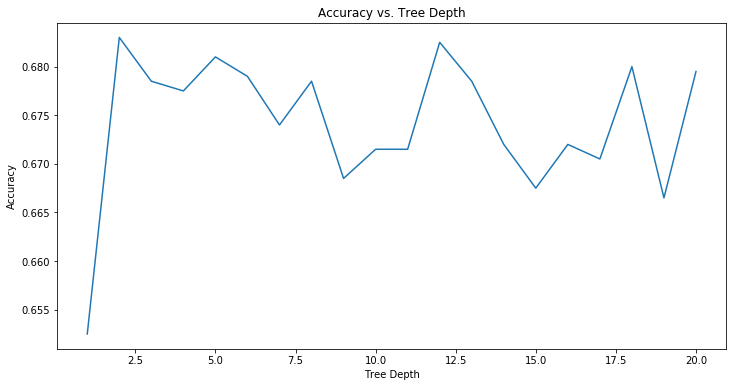

In [13]:
# Compare accuracy of decision trees with different number of depths
accuracy = []
for i in range(1, 21):
    dtree = tree.DecisionTreeClassifier(max_depth=i, random_state=42)
    modelscore = modelaccuracy(dtree)
    accuracy.append(modelscore)
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 21), accuracy)
plt.title('Accuracy vs. Tree Depth') 
plt.xlabel('Tree Depth')  
plt.ylabel('Accuracy') 

In [30]:
# Accuracy of best decision tree
dtree = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
modelresults(dtree)

Accuracy: 0.683
[[506 494]
 [140 860]]
             precision    recall  f1-score   support

        0.0       0.78      0.51      0.61      1000
        1.0       0.64      0.86      0.73      1000

avg / total       0.71      0.68      0.67      2000



## Logistic Regression

In [15]:
# Accuracy of logistic regression
logreg = LogisticRegression()
modelresults(logreg)

Accuracy: 0.797
[[851 149]
 [257 743]]
             precision    recall  f1-score   support

        0.0       0.77      0.85      0.81      1000
        1.0       0.83      0.74      0.79      1000

avg / total       0.80      0.80      0.80      2000



## kNN

Text(0,0.5,'Accuracy')

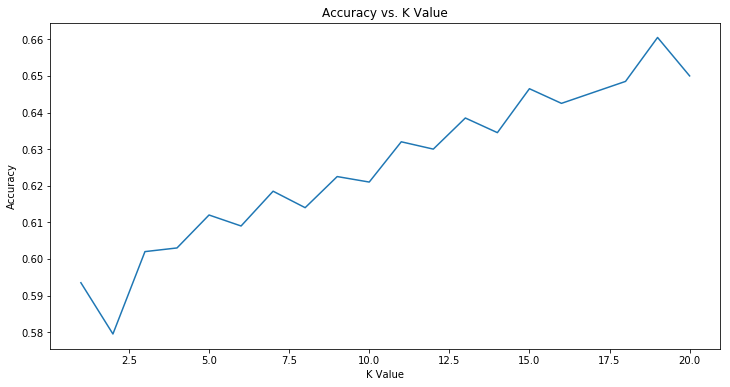

In [16]:
# Compare accuracy of kNNs with different number of ks
accuracy = []
for i in range(1, 21):  
    knn = KNeighborsClassifier(n_neighbors=i)
    modelscore = modelaccuracy(knn)
    accuracy.append(modelscore)
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 21), accuracy)
plt.title('Accuracy vs. K Value') 
plt.xlabel('K Value')  
plt.ylabel('Accuracy') 

In [19]:
# Accuracy of best kNN
knn = KNeighborsClassifier(n_neighbors=19)
modelresults(knn)

Accuracy: 0.6605
[[717 283]
 [396 604]]
             precision    recall  f1-score   support

        0.0       0.64      0.72      0.68      1000
        1.0       0.68      0.60      0.64      1000

avg / total       0.66      0.66      0.66      2000



## Naive Bayes

In [18]:
# Accuracy of naive bayes
nb = GaussianNB()
modelresults(nb)

Accuracy: 0.601
[[880 120]
 [678 322]]
             precision    recall  f1-score   support

        0.0       0.56      0.88      0.69      1000
        1.0       0.73      0.32      0.45      1000

avg / total       0.65      0.60      0.57      2000



# Step 4: Evaluate Models

In [24]:
# Comparing results of each model
model_scores = pd.DataFrame(index = ["Decision Tree", "Logistic Regression", "kNN", "Naive Bayes"], columns=["Accuracy"])

dtree = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
model_scores.at["Decision Tree","Accuracy"] = modelaccuracy(dtree)

logreg = LogisticRegression()
model_scores.at["Logistic Regression","Accuracy"] = modelaccuracy(logreg)

knn = KNeighborsClassifier(n_neighbors=19)
model_scores.at["kNN","Accuracy"] = modelaccuracy(knn)

nb = GaussianNB()
model_scores.at["Naive Bayes","Accuracy"] = modelaccuracy(nb)

model_scores

,Accuracy
Decision Tree,0.683
Logistic Regression,0.797
kNN,0.6605
Naive Bayes,0.601


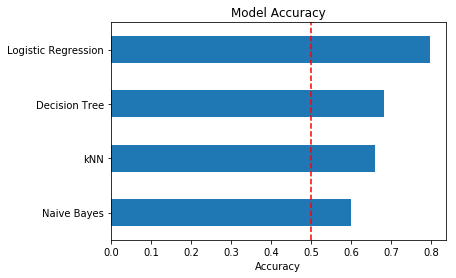

In [25]:
# Plotting model results
model_scores.sort_values("Accuracy", ascending=True).plot.barh(legend=None)
plt.xlabel("Accuracy")
plt.title("Model Accuracy")
plt.axvline(.5, color='red', linestyle='--')
plt.show()

---

### Inspirations:
    
http://ai.stanford.edu/~amaas/data/sentiment/
    
https://nlpforhackers.io/complete-guide-to-spacy/

https://towardsdatascience.com/a-short-introduction-to-nlp-in-python-with-spacy-d0aa819af3ad

https://dl.acm.org/citation.cfm?id=1118704